## Современные библиотеки градиентного бустинга

Ранее мы использовали наивную версию градиентного бустинга из scikit-learn, [придуманную](https://projecteuclid.org/download/pdf_1/euclid.aos/1013203451) в 1999 году Фридманом. С тех пор было предложено много реализаций, которые оказываются лучше на практике. На сегодняшний день популярны три библиотеки, реализующие градиентный бустинг:
* XGBoost. После выхода быстро набрала популярность и оставалась стандартом до конца 2016 года. Одними из основных особенностей имплементации были оптимизированность построения деревьев, а также различные регуляризации модели.
* LightGBM. Отличительной чертой является быстрота построения композиции. Например, используется следующий трюк для ускорения обучения: при построении вершины дерева вместо перебора по всем значениям признака производится перебор значений гистограммы этого признака. Таким образом, вместо $O(\ell)$ требуется $O(\text{#bins})$. Кроме того, в отличие от других библиотек, которые строят дерево по уровням, LightGBM использует стратегию best-first, т.е. на каждом шаге строит вершину, дающую наибольшее уменьшение функционала. Таким образом, каждое дерево является цепочкой с прикрепленными листьями.
* CatBoost. Библиотека от компании Яндекс. Позволяет автоматически обрабатывать категориальные признаки (даже если их значения представлены в виде строк). Кроме того, алгоритм является менее чувствительным к выбору конкретных гиперпараметров. За счёт этого уменьшается время, которое тратит человек на подбор оптимальных гиперпараметров.

### Основные параметры

(lightgbm/catboost)

* `objective` – функционал, на который будет настраиваться композиция
* `eta` / `learning_rate` – темп (скорость) обучения
* `num_iterations` / `n_estimators`  – число итераций бустинга

#### Параметры, отвечающие за сложность деревьев
* `max_depth` – максимальная глубина 
* `max_leaves` / num_leaves – максимальное число вершин в дереве
* `gamma` / `min_gain_to_split` – порог на уменьшение функции ошибки при расщеплении в дереве
* `min_data_in_leaf` – минимальное число объектов в листе
* `min_sum_hessian_in_leaf` – минимальная сумма весов объектов в листе, минимальное число объектов, при котором делается расщепление 
* `lambda` – коэффициент регуляризации (L2)
* `subsample` / `bagging_fraction` – какую часть объектов обучения использовать для построения одного дерева 
* `colsample_bytree` / `feature_fraction` – какую часть признаков использовать для построения одного дерева 

Подбор всех этих параметров — настоящее искусство. Но начать их настройку можно с самых главных параметров: `learning_rate` и `n_estimators`. Обычно один из них фиксируют, а оставшийся из этих двух параметров подбирают (например, фиксируют `n_estimators=1000` и подбирают `learning_rate`). Следующим по важности является `max_depth`. В силу того, что мы заинтересованы в неглубоких деревьях, обычно его перебирают из диапазона [3; 7].

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
!pip install catboost
!pip install lightgbm
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: http://rep.msk.mts.ru/artifactory/api/pypi/pypi/simple
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: http://rep.msk.mts.ru/artifactory/api/pypi/pypi/simple
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: http://rep.msk.mts.ru/artifactory/api/pypi/pypi/simple


In [3]:
from sklearn.datasets import make_classification
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

def plot_surface(X, y, clf):
    h = 0.2
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(8, 8))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

X, y = make_classification(n_samples=500, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0,
                           n_classes=2, n_clusters_per_class=2,
                           flip_y=0.05, class_sep=0.8, random_state=241)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=241)

## Catboost

0.919452347083926


/data/home/irsafilo/course/shad/venv/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


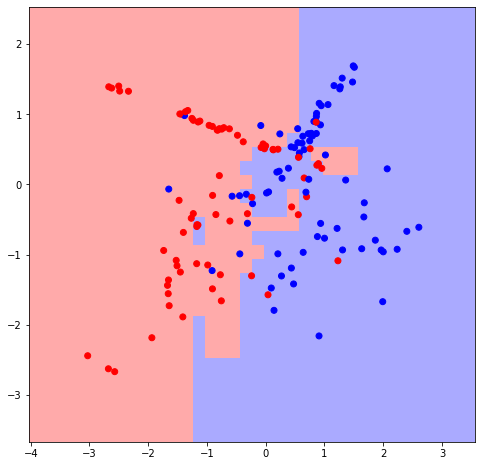

In [4]:
from catboost import CatBoostClassifier 

clf = CatBoostClassifier(iterations=300, logging_level='Silent')
clf.fit(X_train, y_train)
plot_surface(X_test, y_test, clf)

print(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

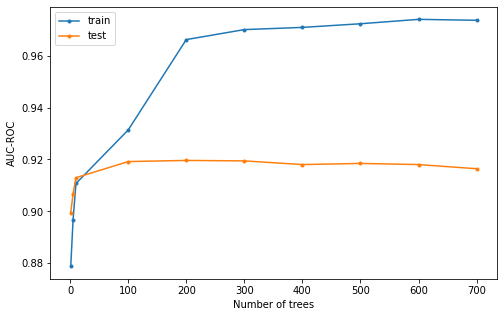

In [5]:
n_trees = [1, 5, 10, 100, 200, 300, 400, 500, 600, 700]
quals_train = []
quals_test = []
for n in n_trees:
    clf = CatBoostClassifier(iterations=n, logging_level='Silent')
    clf.fit(X_train, y_train)
    q_train = roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1])
    q_test = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    quals_train.append(q_train)
    quals_test.append(q_test)
    
plt.figure(figsize=(8, 5))
plt.plot(n_trees, quals_train, marker='.', label='train')
plt.plot(n_trees, quals_test, marker='.', label='test')
plt.xlabel('Number of trees')
plt.ylabel('AUC-ROC')
plt.legend()

plt.show()

## LightGBM

0.8733108108108107


/data/home/irsafilo/course/shad/venv/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


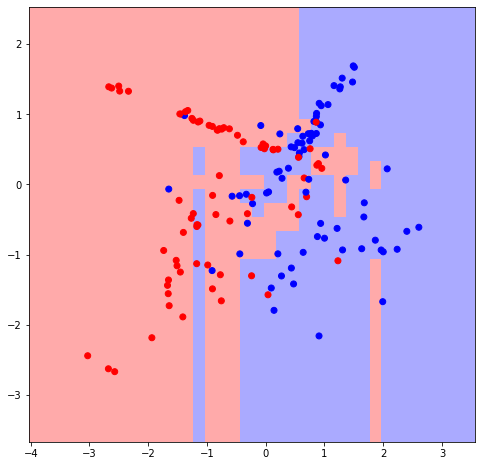

In [6]:
from lightgbm import LGBMClassifier

clf = LGBMClassifier(n_estimators=300)
clf.fit(X_train, y_train)
plot_surface(X_test, y_test, clf)

print(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

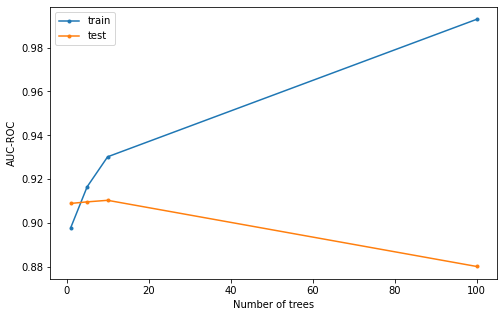

In [7]:
n_trees = [1, 5, 10, 100]
quals_train = []
quals_test = []
for n in n_trees:
    clf = LGBMClassifier(n_estimators=n)
    clf.fit(X_train, y_train)
    q_train = roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1])
    q_test = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    quals_train.append(q_train)
    quals_test.append(q_test)
    
plt.figure(figsize=(8, 5))
plt.plot(n_trees, quals_train, marker='.', label='train')
plt.plot(n_trees, quals_test, marker='.', label='test')
plt.xlabel('Number of trees')
plt.ylabel('AUC-ROC')
plt.legend()

plt.show()

Теперь попробуем взять фиксированное количество деревьев, но будем менять их глубину.

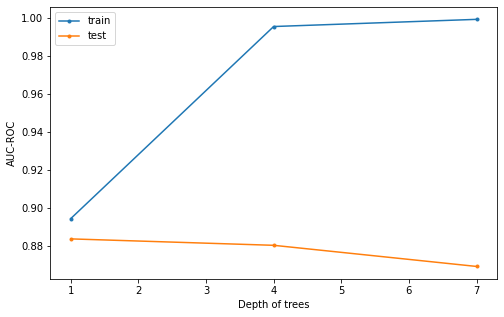

In [8]:
depth = list(range(1, 9, 3))
n_trees = 300
quals_train = []
quals_test = []
for d in depth:
    lgb = LGBMClassifier(n_estimators=n_trees, max_depth=d)
    lgb.fit(X_train, y_train)
    q_train = roc_auc_score(y_train, lgb.predict_proba(X_train)[:, 1])
    q_test = roc_auc_score(y_test, lgb.predict_proba(X_test)[:, 1])
    quals_train.append(q_train)
    quals_test.append(q_test)
    
plt.figure(figsize=(8, 5))
plt.plot(depth, quals_train, marker='.', label='train')
plt.plot(depth, quals_test, marker='.', label='test')
plt.xlabel('Depth of trees')
plt.ylabel('AUC-ROC')
plt.legend()

plt.show()

И сравним с Catboost:

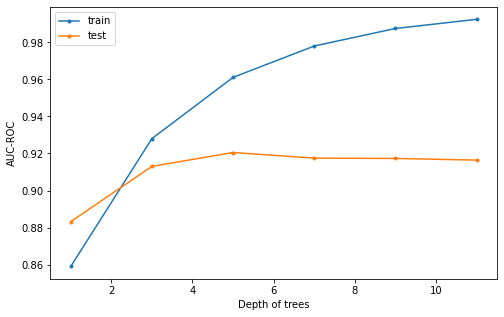

In [9]:
depth = list(range(1, 12, 2))
n_trees = 300
quals_train = []
quals_test = []
for d in depth:
    clf = CatBoostClassifier(n_estimators=n_trees, max_depth=d, logging_level="Silent")
    clf.fit(X_train, y_train)
    q_train = roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1])
    q_test = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    quals_train.append(q_train)
    quals_test.append(q_test)
    
plt.figure(figsize=(8, 5))
plt.plot(depth, quals_train, marker='.', label='train')
plt.plot(depth, quals_test, marker='.', label='test')
plt.xlabel('Depth of trees')
plt.ylabel('AUC-ROC')
plt.legend()

plt.show()

Теперь, когда у нас получились отличные модели, нужно их сохранить!

In [10]:
lgb.booster_.save_model('lightgbm.txt')

clf.save_model('catboost.cbm', format='cbm')

И загрузим обратно, когда понадобится их применить

In [11]:
lgb = LGBMClassifier(model_file='mode.txt')

clf = clf.load_model('catboost.cbm')

## Блендинг

Блендинг представляет из себя "мета-алгоритм", предсказание которого строится как взвешенная сумма базовых алгоритмов. Рассмотрим простой пример блендинга бустинга и линейной регрессии.

In [12]:
from sklearn.datasets import load_boston

data = load_boston()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

def rmse(y_true, y_pred):
    error = (y_true - y_pred) ** 2
    return np.sqrt(np.mean(error))

In [13]:
from catboost import CatBoostRegressor

cbm = CatBoostRegressor(iterations=100, max_depth=4, learning_rate=0.01, loss_function='RMSE', logging_level='Silent')
cbm.fit(X_train, y_train)

y_pred_cbm = cbm.predict(X_test)
y_train_pred_cbm = cbm.predict(X_train)

print("Train RMSE GB = %.4f" % rmse(y_train, y_train_pred_cbm))
print("Test RMSE GB = %.4f" % rmse(y_test, y_pred_cbm))

Train RMSE GB = 5.4431
Test RMSE GB = 6.5456


In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
y_train_pred_lr = lr.predict(X_train_scaled)

print("Train RMSE LR = %.4f" % rmse(y_train, y_train_pred_lr))
print("Test RMSE LR = %.4f" % rmse(y_test, y_pred_lr))

Train RMSE LR = 4.4113
Test RMSE LR = 5.4154


Для простоты будем считать, что новый алгоритм $a(x)$ представим как
$$
    a(x)
    =
    \sum_{n = 1}^{N}
    w_n b_n(x),
$$
где $\sum\limits_{n=1}^N w_n =1$

In [15]:
def select_weights(y_true, y_pred_1, y_pred_2):
    grid = np.linspace(0, 1, 1000)
    metric = []
    for w_0 in grid:
        w_1 = 1 - w_0
        y_a = w_0 * y_pred_1 + w_1 * y_pred_2
        metric.append([rmse(y_true, y_a), w_0, w_1])
    return metric

In [16]:
rmse_blending_train, w_0, w_1 = min(select_weights(y_train, y_train_pred_cbm, y_train_pred_lr), key=lambda x: x[0])

In [17]:
rmse_blending_train

4.273424051954005

In [18]:
rmse(y_test, y_pred_cbm * w_0 +  y_pred_lr * w_1)

5.237314717927903

In [19]:
w_0

0.24524524524524524

In [20]:
w_1

0.7547547547547547

In [35]:
y_train_pred_cbm

array([32.08087384, 20.32694567, 17.53952242, 21.85798031, 22.45636512,
       16.85335059, 18.27228306, 23.15773819, 16.8624866 , 17.7430443 ,
       17.81794991, 17.98796117, 25.72073245, 21.31104489, 22.25429911,
       18.22775465, 22.37633138, 16.83139732, 23.57641349, 19.56688928,
       21.77723757, 27.87580301, 23.91503876, 19.07848181, 16.98435559,
       27.78291755, 19.6122934 , 19.55225548, 20.80638511, 20.79426904,
       22.01875101, 19.11942036, 16.84414204, 29.34661372, 20.62435118,
       18.28558829, 22.37055505, 21.96576445, 22.15433351, 20.44602877,
       24.02848123, 26.13021757, 22.12573176, 24.10977433, 16.95185352,
       21.82158393, 23.25194014, 28.10335777, 22.68818692, 27.07758147,
       22.50981344, 20.09668127, 20.15689041, 21.00906224, 28.12678539,
       22.63589097, 28.36785416, 18.99055359, 21.36309996, 25.41139783,
       25.83463529, 28.54682726, 20.34138096, 19.97178322, 22.69406119,
       31.63171174, 22.20962264, 22.80147703, 19.14472966, 17.88

In [36]:
y_train_pred_lr

array([35.31231704, 20.5131804 , 11.40747798, 16.27533991, 24.5904819 ,
       10.42632247, 15.02055201, 25.97821899, 11.17357006, 11.71266067,
       19.29635756, 19.49836247, 32.39999007, 22.63571608, 25.67695792,
        9.05082205, 21.04375917,  6.79088241, 27.98865469, 21.06957823,
       23.97043996, 24.93815392, 27.12974364, 15.0154284 , 11.79236512,
       23.06580394, 20.46197835, 17.98676715, 22.73161742, 21.01357798,
       22.91716483, 19.49100306,  7.74358253, 32.8998121 , 21.57095713,
       17.11141117, 23.40364719, 23.47519449, 28.50530384, 22.31935862,
       31.2452869 , 34.78233041, 20.67660819, 31.20066591, 16.59407143,
       23.95262796, 21.90329885, 32.20623837, 28.04847935, 33.90562695,
       26.00621849, 21.91351966, 20.29453107, 23.13751427, 33.69867011,
       28.92749867, 30.77000611, 18.04700089, 21.26901808, 30.94275411,
       30.09782122, 36.01293201, 23.83903184, 17.53590914, 23.16151639,
       30.07109419, 21.54565578, 22.50447139, 13.87570863, 15.74

In [38]:
sample = pd.DataFrame([y_train_pred_cbm, y_train_pred_lr]).T

In [39]:
sample

,0,1
0,32.080874,35.312317
1,20.326946,20.513180
2,17.539522,11.407478
3,21.857980,16.275340
4,22.456365,24.590482
...,...,...
349,23.272778,24.913789
350,21.921016,19.872084
351,20.214915,19.165555
352,20.070039,22.410301


In [21]:
from lightgbm import LGBMRegressor

def stack_models(model, y_true, y_pred_1, y_pred_2):
    sample = pd.DataFrame([y_pred_1, y_pred_2]).T
    model.fit(sample, y_true)
    return model

lgb = LGBMRegressor(n_estimators=200, max_depth=3)
lgb = stack_models(lgb, y_train, y_train_pred_cbm, y_train_pred_lr)
rmse(y_test, lgb.predict(pd.DataFrame([y_pred_cbm, y_pred_lr]).T))

4.315187170527423

В итоге получаем качество на тестовой выборке лучше, чем у каждого алгоритма в отдельности.

Полезные ссылки:

* [Видео про стекинг](https://www.coursera.org/lecture/competitive-data-science/stacking-Qdtt6)

## Важность признаков

В курсе мы подробно обсуждаем, как добиваться хорошего качества решения задачи: имея выборку $X, y$, построить алгоритм с наименьшей ошибкой. Однако заказчику часто важно понимать, как работает алгоритм, почему он делает такие предсказания. Обсудим несколько мотиваций.
	
#### Доверие алгоритму
Например, в банках на основе решений, принятых алгоритмом, выполняются финансовые операции, и менеджер, ответственный за эти операции, будет готов использовать алгоритм, только если он понимает, что его решения обоснованы. По этой причине в банках очень часто используют простые линейные алгоритмы. Другой пример из области медицины: поскольку цена ошибки может быть очень велика, врачи готовы использовать только интерпретируемые алгоритмы.
	
#### Отсутствие дискриминации (fairness) 
Вновь пример с банком: алгоритм кредитного скоринга не должен учитывать расовую принадлежность (racial bias) заемщика или его пол (gender bias). Между тем, такие зависимости часто могут присутствовать в датасете (исторические данные), на котором обучался алгоритм.  Еще один пример: известно, что нейросетевые векторы слов содержат gender bias. Если эти вектора использовались при построении системы поиска по резюме для рекрутера, то, например, по запросу `technical skill` он может видеть женские резюме в конце ранжированного списка.
	
#### Учет контекста
Данные, на которых обучается алгоритм, не отображают всю предметную область. Интерпретация алгоритма позволит оценить, насколько найденные зависимости связаны с реальной жизнью. Если предсказания интерпретируемы, это также говорит о высокой обобщающей способности алгоритма. 

Теперь обсудим несколько вариантов, как можно оценивать важность признаков.

### Веса линейной модели

Самый простой способ, который уже был рассмотрен на семинаре про линейные модели: после построения модели каждому признаку будет соответствовать свой вес - если признаки масштабированы, то чем он больше по модулю, тем важнее признак, а знак будет говорить о положительном или отрицательном влиянии на величину целевой переменной.

### FSTR (Feature strength)

[Fstr](https://catboost.ai/docs/concepts/fstr.html) говорит, что важность признака &mdash; это то, насколько в среднем меняется ответ модели при изменении значения данного признака (изменении значения разбиения).

Рассчитать его можно так:

$$feature\_importance_{F} = \sum_{tree, leaves_F} (v_1 - avr)^2\cdot c_1 +(v_2 - avr)^2\cdot c_2 = \left(v_1 - v_2\right)^2\frac{c_1c_2}{c_1 + c_2}\\
\qquad avr = \frac{v_1 \cdot c_1 + v_2 \cdot c_2}{c_1 + c_2}.$$

Мы сравниваем листы, отличающиеся значением сплита в узле на пути к ним: если условие сплита выполняется, объект попадает в левое поддерево, иначе &mdash; в правое. 

$c_1, c_2$ - число объектов обучающего датасета, попавших в левое и правое поддерево соответственно, либо суммарный вес этих объектов, если используются веса; $v_1, v_2$ - значение модели в левом и правом поддереве (например, среднее)


Далее значения $feature\_importance$ нормируются, и получаются величины, которые суммируются в 100.

In [22]:
for val, name in sorted(zip(cbm.feature_importances_, data.feature_names))[::-1]:
    print(name, val)

LSTAT 44.57842395824728
RM 36.850858175652654
NOX 3.473133901367306
PTRATIO 3.3887271637105134
DIS 2.23667053074621
INDUS 1.9016830079470277
TAX 1.7781003730136429
CRIM 1.5774334311195715
AGE 1.4213295189456003
RAD 1.3943420902109485
B 0.6521915521536685
CHAS 0.6057385942178969
ZN 0.14136770266764145


In [23]:
sum(cbm.feature_importances_)

99.99999999999996

### Out-of-bag

В случайном лесе за счет обучения на подвыборках можно использовать out-of-bag оценки - ошибка композиции $a(x) = \sum_{n=1}^N b_n(x)$, построенной с помощью бэггинга с базовыми алгоритмами $b_i(x)$, вычисляется по формуле (подробнее см. конспект лекции 8):
     $$
     \text{OOB} = \sum_{i=1}^\ell L\biggl(y_i, \frac 1 {\sum_{n=1}^N [x_i \notin X_n]} \sum_{n=1}^N [x_i \notin X_n] b_n(x_i)\biggr)
      $$     
Можно показать, что по мере увеличения числа деревьев 
данная оценка стремится к leave-one-out-оценке,
но при этом существенно проще для вычисления.
     
Итоговый алгоритм подсчета важностей для случайного леса выглядит так:
* Вычислить OOB для случайного леса, обученного по исходной обучающей выборке
*  Для каждого признака $j$:

    * Перемешать значения признака по всем объектам обучающей выборки &mdash; мы хотим сделать признак неинформативным
    * Вычислить OOB$_j$ случайного леса, обученного по измененной обучающей выборке
    * Оценить важности: $R_j = \max(0, \text{OOB}-\text{OOB}_j)$

Приведем простейший пример, как можно получить такую оценку в sklearn-реализации RandomForest

In [24]:
from sklearn.ensemble import RandomForestRegressor

clf = RandomForestRegressor(n_estimators=100, oob_score=True)
clf.fit(X_train, y_train)

clf.oob_score_

0.8448576697451783

## XGBoost

In [25]:
# based on https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import metrics   #Additional sklearn functions
from sklearn.model_selection import learning_curve, GridSearchCV  #Perforing grid search
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
from sklearn.datasets import load_breast_cancer, fetch_lfw_pairs, make_classification
rcParams['figure.figsize'] = 12, 4

In [26]:
titanic = pd.read_csv('titanic.csv')

In [27]:
X = titanic[['Pclass', 'Age', 'SibSp', 'Fare']]
y = titanic.Survived.values

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((712, 4), (712,), (179, 4), (179,))

In [30]:
def modelfit(alg, dtrain, y, X_test=None, y_test=None, test=True, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain, label=y)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain, y, eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain)
    dtrain_predprob = alg.predict_proba(dtrain)[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy (Train): %.4g" % metrics.accuracy_score(y, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(y, dtrain_predprob))
    if test:
        dtest_predictions = alg.predict(X_test)
        dtest_predprob = alg.predict_proba(X_test)[:,1]
        print ("Accuracy (Test): %.4g" % metrics.accuracy_score(y_test, dtest_predictions))
        print ("AUC Score (Test): %f" % metrics.roc_auc_score(y_test, dtest_predprob))
    # return alg              
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [31]:
#Choose all predictors except target & IDcols
# predictors = [x for x in X.columns]
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 booster='gbtree',
 seed=27)


Model Report
Accuracy (Train): 0.7697
AUC Score (Train): 0.864482
Accuracy (Test): 0.7542
AUC Score (Test): 0.815251


/data/home/irsafilo/course/shad/venv/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


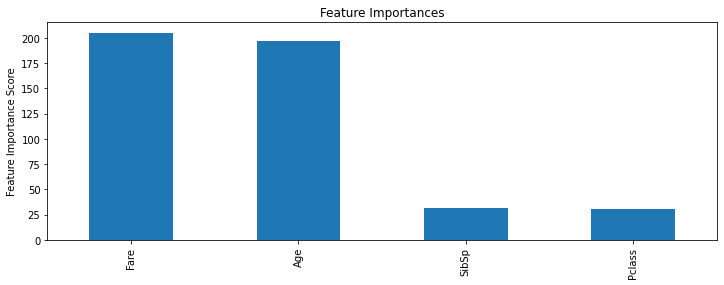

In [32]:
modelfit(xgb1, X_train, y_train, X_test, y_test)

In [33]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4, cv=5)
gsearch1.fit(X_train, y_train)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

[17:22:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/data/home/irsafilo/course/shad/venv/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


({'mean_fit_time': array([0.07557712, 0.05890322, 0.05761609, 0.08898077, 0.08321819,
         0.07912998, 0.11836257, 0.1026474 , 0.09396348, 0.14731383,
         0.11403561, 0.09486856]),
  'std_fit_time': array([0.00975719, 0.00231115, 0.00144791, 0.00269516, 0.00236627,
         0.00214271, 0.00275762, 0.00169324, 0.00313121, 0.0041183 ,
         0.00231644, 0.00086373]),
  'mean_score_time': array([0.00274973, 0.00254045, 0.00244727, 0.00247703, 0.00255117,
         0.0025238 , 0.00273848, 0.00264583, 0.00262494, 0.00396705,
         0.00288439, 0.00263762]),
  'std_score_time': array([1.12788308e-04, 1.87900016e-04, 1.27923297e-04, 6.80748466e-05,
         7.98740813e-05, 4.30796973e-05, 1.61074505e-04, 1.11384669e-04,
         1.07717651e-04, 1.88906455e-03, 2.77941136e-04, 1.33930308e-04]),
  'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, F

In [42]:
param_test2 = {
 'max_depth':[8,9,10],
 'min_child_weight':[4, 5, 6]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4, cv=5)
gsearch2.fit(X_train, y_train)
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_

[17:40:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/data/home/irsafilo/course/shad/venv/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


({'mean_fit_time': array([0.0967669 , 0.07615314, 0.08015032, 0.08364477, 0.07672687,
         0.07674241, 0.09848514, 0.091535  , 0.08241529]),
  'std_fit_time': array([0.02212361, 0.01650682, 0.01362167, 0.01923072, 0.01735391,
         0.01246315, 0.00425357, 0.00367275, 0.00435445]),
  'mean_score_time': array([0.00292401, 0.00258465, 0.00266185, 0.00264854, 0.00260248,
         0.00267706, 0.00295749, 0.00291252, 0.00292163]),
  'std_score_time': array([0.00019605, 0.00021189, 0.00022226, 0.00026976, 0.00022372,
         0.00023473, 0.00022887, 0.00024629, 0.0004795 ]),
  'param_max_depth': masked_array(data=[8, 8, 8, 9, 9, 9, 10, 10, 10],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_min_child_weight': masked_array(data=[4, 5, 6, 4, 5, 6, 4, 5, 6],
               mask=[False, False, False, False, False, False, False, False,
                     False],
      

In [43]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=9,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4, cv=5)
gsearch3.fit(X_train, y_train)
gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_

/data/home/irsafilo/course/shad/venv/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/data/home/irsafilo/course/shad/venv/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/data/home/irsafilo/course/shad/venv/lib/python3

[17:41:12] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/data/home/irsafilo/course/shad/venv/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/data/home/irsafilo/course/shad/venv/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/data/home/irsafilo/course/shad/venv/lib/python3

({'mean_fit_time': array([0.08773103, 0.08978915, 0.09364834, 0.08578625, 0.08961835]),
  'std_fit_time': array([0.0070269 , 0.00626982, 0.01088965, 0.006099  , 0.00426697]),
  'mean_score_time': array([0.00332556, 0.00388699, 0.00482917, 0.00286169, 0.0029212 ]),
  'std_score_time': array([0.00012834, 0.00155577, 0.00198646, 0.00018046, 0.00015971]),
  'param_gamma': masked_array(data=[0.0, 0.1, 0.2, 0.3, 0.4],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'gamma': 0.0},
   {'gamma': 0.1},
   {'gamma': 0.2},
   {'gamma': 0.3},
   {'gamma': 0.4}],
  'split0_test_score': array([0.68997087, 0.68934665, 0.69350811, 0.68768206, 0.6951727 ]),
  'split1_test_score': array([0.73491469, 0.73907615, 0.74282147, 0.73012901, 0.7372035 ]),
  'split2_test_score': array([0.75524698, 0.74856901, 0.76001696, 0.74750901, 0.75747297]),
  'split3_test_score': array([0.71168115, 0.71146915, 0.71380114, 0.71634513, 0.71443714]),


Model Report
Accuracy (Train): 0.7416
AUC Score (Train): 0.802865
Accuracy (Test): 0.7263
AUC Score (Test): 0.801416


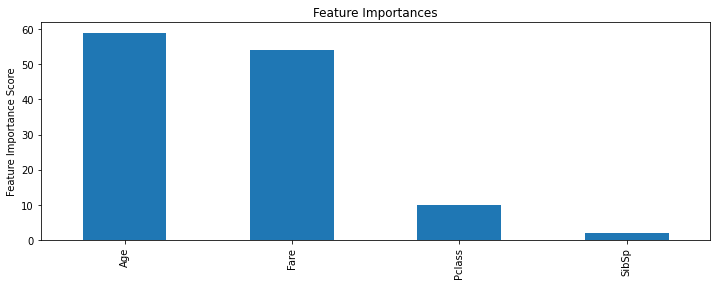

In [44]:
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=9,
 min_child_weight=6,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 booster='gbtree',
 seed=27)
modelfit(xgb2, X_train, y_train, X_test, y_test)

In [45]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=9,
 min_child_weight=6, gamma=0., subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4, cv=5)
gsearch4.fit(X_train, y_train)
gsearch4.cv_results_, gsearch4.best_params_, gsearch4.best_score_

/data/home/irsafilo/course/shad/venv/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/data/home/irsafilo/course/shad/venv/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/data/home/irsafilo/course/shad/venv/lib/python3

[17:40:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:40:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:40:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:40:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/data/home/irsafilo/course/shad/venv/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/data/home/irsafilo/course/shad/venv/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/data/home/irsafilo/course/shad/venv/lib/python3

[17:40:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:40:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:40:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:40:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/data/home/irsafilo/course/shad/venv/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/data/home/irsafilo/course/shad/venv/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/data/home/irsafilo/course/shad/venv/lib/python3

[17:40:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:40:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:40:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:40:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[17:41:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.[17:41:15] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/data/home/irsafilo/course/shad/venv/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


({'mean_fit_time': array([0.08857374, 0.09348125, 0.10353212, 0.10212517, 0.09214063,
         0.09407616, 0.09874587, 0.1092732 , 0.09532671, 0.10521412,
         0.10892262, 0.11749353, 0.09898343, 0.10157065, 0.11680131,
         0.11665235]),
  'std_fit_time': array([0.00775376, 0.00769223, 0.0046933 , 0.00809687, 0.00676194,
         0.00615535, 0.00927301, 0.00517373, 0.00426974, 0.00724218,
         0.00561125, 0.00870621, 0.00625662, 0.00578415, 0.00569245,
         0.00683363]),
  'mean_score_time': array([0.00335798, 0.00334516, 0.00339079, 0.00343924, 0.00328784,
         0.00320411, 0.00322256, 0.00340447, 0.0029345 , 0.00310192,
         0.00313039, 0.00307536, 0.00316525, 0.00304713, 0.00408487,
         0.00558691]),
  'std_score_time': array([3.62024619e-05, 8.59813692e-05, 6.49400743e-05, 2.76690488e-05,
         5.19173413e-05, 3.09624874e-05, 8.59563755e-05, 2.51224163e-04,
         1.84742580e-04, 7.26147377e-05, 2.38006254e-04, 3.80104214e-04,
         9.03461087e-

In [47]:
param_test5 = {
 'subsample':[i/100.0 for i in range(55, 70, 5)],
 'colsample_bytree':[i/100.0 for i in range(55, 70,5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=9,
 min_child_weight=6, gamma=0., subsample=0.6, colsample_bytree=0.6,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=4, cv=5)
gsearch5.fit(X_train, y_train)
gsearch5.cv_results_, gsearch5.best_params_, gsearch5.best_score_

/data/home/irsafilo/course/shad/venv/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/data/home/irsafilo/course/shad/venv/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/data/home/irsafilo/course/shad/venv/lib/python3

[17:41:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/data/home/irsafilo/course/shad/venv/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


({'mean_fit_time': array([0.08549514, 0.08715992, 0.09374657, 0.08339081, 0.09082613,
         0.0909493 , 0.07949505, 0.08484678, 0.08563881]),
  'std_fit_time': array([0.0047941 , 0.00641275, 0.00301346, 0.00487644, 0.00520061,
         0.00365697, 0.00453523, 0.00470895, 0.00433269]),
  'mean_score_time': array([0.00393219, 0.0027544 , 0.00276065, 0.00261664, 0.00299931,
         0.00348201, 0.00321198, 0.00287209, 0.00294352]),
  'std_score_time': array([9.76565054e-04, 1.46150037e-04, 1.13398954e-04, 5.90947274e-05,
         4.91020664e-04, 1.02158822e-03, 1.10355304e-04, 7.17072722e-05,
         1.53692465e-04]),
  'param_colsample_bytree': masked_array(data=[0.55, 0.55, 0.55, 0.6, 0.6, 0.6, 0.65, 0.65, 0.65],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_subsample': masked_array(data=[0.55, 0.6, 0.65, 0.55, 0.6, 0.65, 0.55, 0.6, 0.65],
               mask=[F

In [48]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=9,
 min_child_weight=6, gamma=0., subsample=0.6, colsample_bytree=0.55,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4, cv=5)
gsearch6.fit(X_train, y_train)
gsearch6.cv_results_, gsearch6.best_params_, gsearch6.best_score_

/data/home/irsafilo/course/shad/venv/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/data/home/irsafilo/course/shad/venv/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/data/home/irsafilo/course/shad/venv/lib/python3

/data/home/irsafilo/course/shad/venv/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/data/home/irsafilo/course/shad/venv/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/data/home/irsafilo/course/shad/venv/lib/python3

[17:41:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


({'mean_fit_time': array([0.08685899, 0.08347797, 0.08585968, 0.07676349, 0.03530316]),
  'std_fit_time': array([0.00372788, 0.00615702, 0.00430233, 0.00350098, 0.00052723]),
  'mean_score_time': array([0.00407066, 0.0034699 , 0.00303292, 0.00282354, 0.00233192]),
  'std_score_time': array([0.00056646, 0.0005959 , 0.00013738, 0.00013798, 0.0001082 ]),
  'param_reg_alpha': masked_array(data=[1e-05, 0.01, 0.1, 1, 100],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'reg_alpha': 1e-05},
   {'reg_alpha': 0.01},
   {'reg_alpha': 0.1},
   {'reg_alpha': 1},
   {'reg_alpha': 100}],
  'split0_test_score': array([0.70079068, 0.70411985, 0.6971494 , 0.70422389, 0.5       ]),
  'split1_test_score': array([0.7437578 , 0.73813983, 0.74313358, 0.74354973, 0.5       ]),
  'split2_test_score': array([0.77824889, 0.78164087, 0.78015688, 0.78492686, 0.5       ]),
  'split3_test_score': array([0.72948908, 0.72927708, 0.72694509,


Model Report
Accuracy (Train): 0.7767
AUC Score (Train): 0.853011
Accuracy (Test): 0.7542
AUC Score (Test): 0.800064


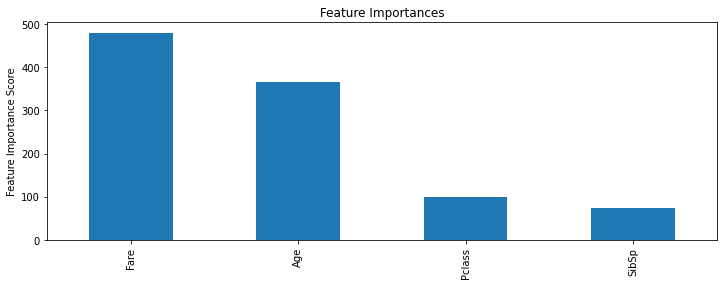

In [49]:
xgb3 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=9,
 min_child_weight=6,
 gamma=0,
 subsample=0.6,
 colsample_bytree=0.55,
 reg_alpha = 1e-05,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb3, X_train, y_train, X_test, y_test)

/data/home/irsafilo/course/shad/venv/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Model Report
Accuracy (Train): 0.7697
AUC Score (Train): 0.845969
Accuracy (Test): 0.7598
AUC Score (Test): 0.809717


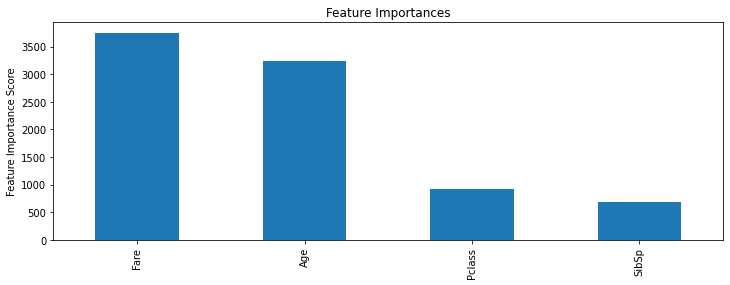

/data/home/irsafilo/course/shad/venv/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/data/home/irsafilo/course/shad/venv/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/data/home/irsafilo/course/shad/venv/lib/python3


[17:41:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:41:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:41:28] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:41:28] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old b


[17:41:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:41:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:41:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:41:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old b

/data/home/irsafilo/course/shad/venv/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/data/home/irsafilo/course/shad/venv/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/data/home/irsafilo/course/shad/venv/lib/python3

In [50]:
xgb3 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=5000,
 max_depth=9,
 min_child_weight=6,
 gamma=0,
 subsample=0.6,
 colsample_bytree=0.55,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb3, X_train, y_train, X_test, y_test, early_stopping_rounds=500)